## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

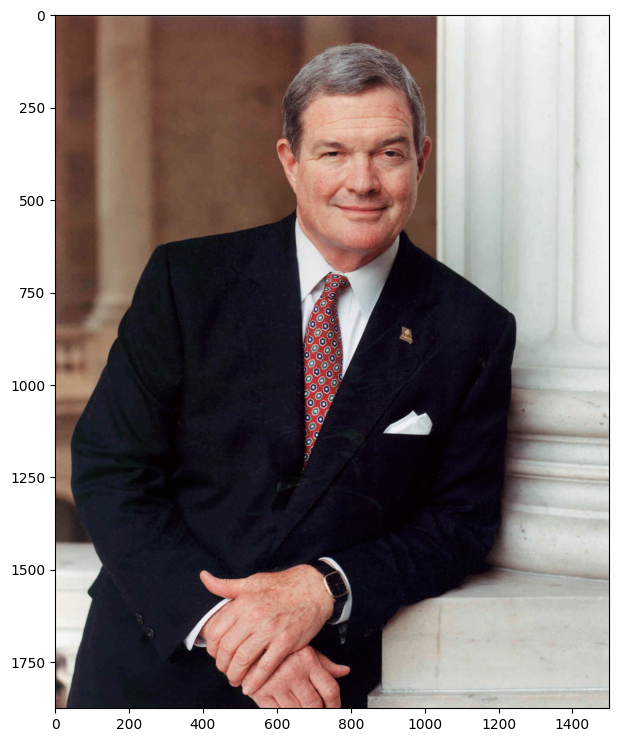

In [2]:
import cv2
# load in color image for face detection
# image = cv2.imread('images/the_beatles.jpg')
# image = cv2.imread('images/mona_lisa.jpg')
# image = cv2.imread('images/obamas.jpg')
# image = cv2.imread('images/Kit_Bond_30.jpg')
image = cv2.imread('images/Kit_Bond_large.jpg')


# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


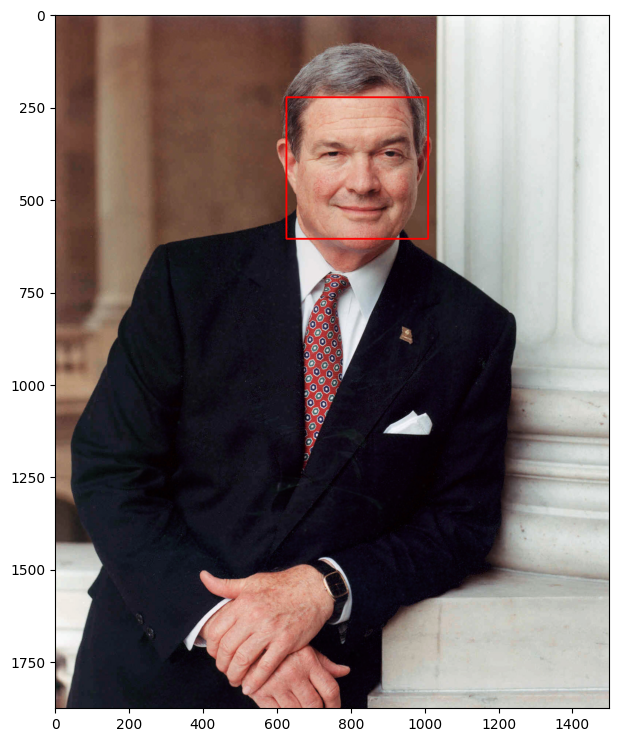

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.3, 5)  # changed these to reduce some false positives, by increasing scale factor and minNeighbors

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch
from models import Net

net = Net()
       
## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model

print(f"pre-load weights sampling:")
print(net.conv1.weight.shape)
print(net.conv1.weight[0, :, :, :])

net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

print(f"post-load weights sampling:")
print(net.conv1.weight.shape)
print(net.conv1.weight[0, :, :, :])

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

pre-load weights sampling:
torch.Size([32, 1, 5, 5])
tensor([[[ 0.1423, -0.0538, -0.1982, -0.0547,  0.0126],
         [-0.1705, -0.1101, -0.1965, -0.1263, -0.1157],
         [-0.1374, -0.1681, -0.1593,  0.0111, -0.1080],
         [-0.1292,  0.1458, -0.0697, -0.1917, -0.1290],
         [-0.1556,  0.0942,  0.1031, -0.1739, -0.0284]]],
       grad_fn=<SliceBackward0>)


RuntimeError: Error(s) in loading state_dict for Net:
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "fc1_bn.weight", "fc1_bn.bias", "fc1_bn.running_mean", "fc1_bn.running_var", "fc1_bn.num_batches_tracked". 

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




(583, 583)
(224, 224)
(1, 224, 224)
(1, 1, 224, 224)
torch.Size([1, 136])
(68, 2)


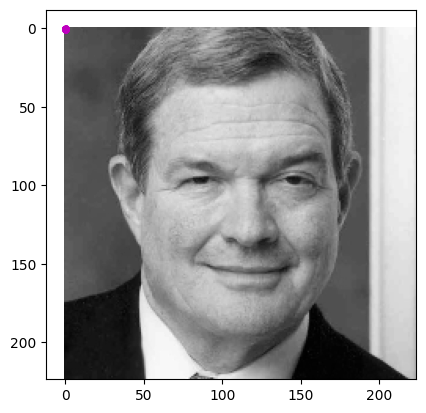

In [5]:
image_copy = np.copy(image)

# def show_all_keypoints(image, keypoints):  
#     batch_size = len(image)
#     for i, face in enumerate(image):
#         plt.figure(figsize=(8, 8))
#         ax = plt.subplot(1, batch_size, i+1)
#         # un-transform the predicted key_pts data
#         predicted_keypoints = keypoints[i].data
#         predicted_keypoints = predicted_keypoints.numpy()
#         # undo normalization of keypoints  
#         predicted_keypoints = predicted_keypoints*50.0+100
#         plt.imshow(face, cmap='gray')
#         plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='m')
        
#         plt.axis('off')
#     plt.show()

# images, keypoints = [], []  # multiple faces possible


# # NOTE: This function is same as the one provided by Udacity as template code in the previous notebook. 
# def show_all_keypoints(image, predicted_key_pts):
#     """Show image with predicted keypoints"""
#     # image is grayscale
#     plt.figure()
#     plt.imshow(image, cmap='gray')
#     plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')




PADDING = 100  # give some extra around the face so trained model works well

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]

    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    print(roi.shape)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = (roi / 255.0).astype(np.float32)

    # print(roi)
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    # images.append(roi)
    face_copy = np.copy(roi)
    
    print(roi.shape)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # Shape of roi is just (224, 224) so actually just need to add a channels dimension to front with reshaping
    roi = np.expand_dims(roi, axis=0)

    print(roi.shape)
    # roi = roi.transpose((2, 0, 1))

    # add another dimension one more time for the batch size of 1
    roi = np.expand_dims(roi, axis=0)

    print(roi.shape)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints

    # need to make into a tensor before forward pass
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    
    key_pts = net.forward(roi)

    # reshape to batch_size x 68 x 2?
    # key_pts = key_pts.view(key_pts.size()[0], 68, -1)

    ## TODO: Display each detected face and the corresponding keypoints        
    # undo the normalization of keypoints
    # key_pts = key_pts * 50.0 + 100
    # key_pts = (key_pts - 100) / 50.0

    print(key_pts.shape)

    key_pts = key_pts.view(68, 2)  # reshape
    key_pts = key_pts.detach().numpy()
    # key_pts = key_pts * 50.0 + 100
    # key_pts = key_pts * (10, 10)  # FIXME
    print(key_pts.shape)
    
    # # key_pts is (1, 136) (one long row vectors) and we want it to be in 68 rows, of x/y columns
    # key_pts = key_pts.detach().numpy()  # not really sure, got an error code that required this.  need to convert to tensor that doesn't require gradient.
    # key_pts = np.reshape(key_pts, (68, -1))  # -1 auto-calculate missing dimension size
    # # keypoints.append(key_pts[0])
    
    # # print(key_pts)

    # plot on top of image
    plt.imshow(face_copy, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

    break # just plot one face

    # plt.figure()
    # show_all_keypoints(face_copy, keypoints)
    # plt.show()

# show_all_keypoints(images, keypoints)

